<a href="https://colab.research.google.com/github/lipeng2021/-python1/blob/main/softmax_easy3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torchvision
from IPython import display
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import sys
import time
import torch.nn.init as init
FILENAME = './content/sample_data/lipeng'

In [3]:
mnist_train = torchvision.datasets.FashionMNIST(root=FILENAME,train=True,download=True,transform=transforms.ToTensor(),)
mnist_test = torchvision.datasets.FashionMNIST(root=FILENAME,train=False,download=True,transform=transforms.ToTensor(),)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./content/sample_data/lipeng/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./content/sample_data/lipeng/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./content/sample_data/lipeng/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./content/sample_data/lipeng/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./content/sample_data/lipeng/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./content/sample_data/lipeng/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./content/sample_data/lipeng/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./content/sample_data/lipeng/FashionMNIST/raw



In [4]:
def use_svg_figures():
  display.set_matplotlib_formats('svg')

In [5]:
def get_fashion_mnist_labels(labels):
  text_labels = ['t-shirt','trouser','pullover','dress','coat','sandal','sneaker','bag','ankle','boot']
  return (text_labels[int(i)] for i in labels)

In [6]:
def show_fashion_mnist(images,labels):
  _,figs = plt.subplots(1,len(images),figsize=(12,12))
  for fig,image,lbl in zip(figs,images,labels):
    fig.imshow(image.view(28,28).numpy())
    fig.set_title(lbl)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
  plt.show()


读取数据

In [7]:
batch_size=256
if sys.platform.startswith('win'):
  num_workers = 0
else:
  num_workers = 2
train_iter = torch.utils.data.DataLoader(mnist_train,batch_size,shuffle=True,num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(mnist_test,batch_size,shuffle=True,num_workers=num_workers)

定义模型

In [8]:
num_inputs = 784
num_outputs = 10
class LinearNet(nn.Module):
  def __init__(self,num_inputs,num_outputs) -> None:
      super(LinearNet,self).__init__()
      self.linear = nn.Linear(num_inputs,num_outputs)
  def forward(self,x):
    y = self.linear(x.view(x.shape[0],-1))
    return y
net = LinearNet(num_inputs,num_outputs)

In [12]:
class FlattenLayer(nn.Module):
  def __init__(self):
    super(FlattenLayer,self).__init__()
  def forward(self,x):
    return x.view(x.shape[0],-1)

In [13]:
from collections import OrderedDict
net = nn.Sequential(
    OrderedDict([
      ('flatten',FlattenLayer()),
      ('linear',nn.Linear(num_inputs,num_outputs))
    ])
)

初始化函数参数

In [ ]:
init.normal_(net.linear.weight,mean=0,std=0.01)
init.constant_(net.linear.bias,val=0)

定义损失函数

In [15]:
loss = nn.CrossEntropyLoss()

定义优化算法

In [16]:
optimizer = torch.optim.SGD(net.parameters(),lr=0.1)

In [21]:
def sgd(params,lr,batch_size):
  for param in params:
    param.data -=lr*param.grad/batch_size

In [22]:
def evaluate_accuracy(data_iter,net):
  acc_sum=0.0
  n=0;
  for X,y in data_iter:
    acc_sum += (net(X).argmax(dim=1)==y).float().sum().item()
    n += y.shape[0]
    return acc_sum/n

训练模型

In [17]:
num_epoch =5
def train_ch3(net,train_iter,test_iter,loss,num_epoch,batch_size,params=None,lr=None,optimizer=None):
  for epoch in range(num_epoch):
    train_l_sum=0.0
    train_acc_sum=0.0
    n = 0
    for X,y in train_iter:
      y_hat = net(X)
      l = loss(y_hat,y).sum()
      if optimizer is not None:
        optimizer.zero_grad()
      elif params is not None and params[0].grad is not None:
        for param in params:
          param.grad.data.zero_()
      l.backward()
      if optimizer is None:
        sgd(params,lr,batch_size)
      else:
        optimizer.step()
      train_l_sum += l.item()
      train_acc_sum +=(y_hat.argmax(dim=1)==y).float().sum().item()
      n +=y.shape[0]
      test_acc=evaluate_accuracy(test_iter,net)
    print('epoch%d,loss%.4f,trainacc %.3f,test acc %.3f'%(epoch+1,train_l_sum/n,train_acc_sum/n,test_acc))

In [23]:
train_ch3(net,train_iter,test_iter,loss,num_epoch,batch_size,None,None,optimizer)

epoch1,loss0.0031,trainacc 0.751,test acc 0.762
epoch2,loss0.0022,trainacc 0.813,test acc 0.762
epoch3,loss0.0021,trainacc 0.826,test acc 0.855
epoch4,loss0.0020,trainacc 0.831,test acc 0.797
epoch5,loss0.0019,trainacc 0.838,test acc 0.844


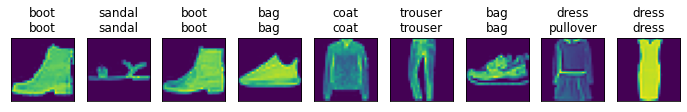

In [32]:
from numpy import True_
X,y = iter(test_iter).next()
true_labels = get_fashion_mnist_labels(y.numpy())
pred_labels = get_fashion_mnist_labels(net(X).argmax(dim=1).numpy())
titles = [true + '\n' + pred for true,pred in zip(true_labels,pred_labels)]
show_fashion_mnist(X[0:9],titles[0:9])
